# Machine Learning Models for SCOPE: Ada Boost Classifier
Models will be coded here, but the official write up will be in the RMarkdown document.

In [ ]:
# load the data files
import pandas as pd
import numpy as np
from pymodelutils import utils

logs = pd.read_csv("data/metis_logs.csv")
logs.head()

In [ ]:
# filter down to show the average opinion (0 means no alert, 1 means alert)
logs['run_date'] = logs['run_date'].astype('datetime64[ns]')
logs['is_alert'] = (np.where(logs['is_alert'] == 'f', 0, 1))
logs = logs.groupby(['series', 'kpi', 'run_date']).mean().round(0).reset_index()
logs['is_campaign'] = np.where(logs['campaign_id'] > 0, 1, 0)
logs = logs.drop(columns=['client_id', 'partner_id', 'campaign_id'])
logs['is_alert'].describe()

In [ ]:
AS_data = pd.read_csv("data/python_AS.csv")
AS_data.head()

In [ ]:
TS_data = pd.read_csv("data/python_TS.csv")
TS_data.head()

In [ ]:
RexT_data = pd.read_csv("data/python_RexT.csv")
RexT_data.head()

## Data Prep
R has already filtered down the data to the days we are going to use and marked what is disqualified. We still have to handle the feature selection and one-hot encoding of select columns though. We also need to normalize it since out KPIs behave quite differently.

In [ ]:
# add column for AS to tell if it is campaign level or not
AS_data['is_campaign'] = np.where(AS_data['campaign_id'] > 0, 1, 0)

# drop the data we don't need for the model or for matching back to the logs
AS_keep_columns = ['series', 'day', 'run_date', 'kpi', 'value', 'disqualified', 'is_campaign']
TS_keep_columns = ['series', 'day', 'run_date', 'site_type', 'event_name', 
                   'kpi', 'value', 'disqualified']
RexT_drop_columns = ['ranking',
                    'day_of_week',
                    'day_of_month',
                    'month_of_year',
                    'day_of_year',
                    'week_of_year']

AS_data = AS_data[AS_keep_columns]
TS_data = TS_data[TS_keep_columns]
RexT_data = RexT_data.drop(columns=RexT_drop_columns)

In [ ]:
AS_data.head()

In [ ]:
TS_data.head()

In [ ]:
RexT_data.head()

In [ ]:
# add a new column to determine how many days before the run_date the day column entry is
# this will enable us to pivot that data into separate columns for the features of our model
utils.prep_dates(AS_data)
utils.prep_dates(TS_data)
utils.prep_dates(RexT_data)

In [ ]:
# inner joins to logs
AS_data = pd.merge(AS_data, logs, on=['series', 'run_date', 'kpi', 'is_campaign'], how='inner')
TS_data = pd.merge(TS_data, logs, on=['series', 'run_date', 'kpi'], how='inner')
RexT_data = pd.merge(RexT_data, logs, on=['series', 'run_date', 'kpi'], how='inner')

In [ ]:
# filter out the disqualified data (AS and TS data only)
AS_disqualified = AS_data[AS_data.disqualified]
TS_disqualified = TS_data[TS_data.disqualified]

# valid for model (AS and TS data only)
valid_AS_raw = AS_data[~(AS_data.disqualified)]
valid_TS_raw = TS_data[~(TS_data.disqualified)]

# keep a copy of the raw RexT data
RexT_data_raw = RexT_data.copy(deep=True)

In [ ]:
# final preparations to the data shape for use in the model
valid_AS = utils.data_prep_pipeline(valid_AS_raw.copy(), 
                                      indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                      cols=['kpi'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
disqualified_AS = utils.data_prep_pipeline(AS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'kpi', 'is_campaign', 'is_alert'], 
                                          cols=['kpi'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_TS = utils.data_prep_pipeline(valid_TS_raw.copy(), 
                                      indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                      cols=['site_type', 'event_name'],
                                      scaling_method=['standardize', 'min_max', 'percent_of_mean'])
disqualified_TS = utils.data_prep_pipeline(TS_disqualified.copy(), 
                                          indices=['series', 'run_date', 'site_type', 'event_name', 'is_alert'], 
                                          cols=['site_type', 'event_name'],
                                          scaling_method=['standardize', 'min_max', 'percent_of_mean'])
valid_RexT = utils.data_prep_pipeline(utils.clean_regions(RexT_data), 
                                       indices=['isCountry', 'isSubregion', 'isRegion', 
                                                'series', 'run_date', 'is_alert'], 
                                       cols=['series'],
                                       scaling_method=['standardize', 'min_max', 'percent_of_mean'])

In [ ]:
# for the TS data we need to drop event_name_SITE LEVEL because it will always be the same as site_type_SITE LEVEL
valid_TS = {key : value.drop(columns='event_name_SITE LEVEL') for key, value in valid_TS.items()}

# add back missing columns for the disqualified data
disqualified_TS['min_max']['time_delta_24'], disqualified_TS['min_max']['time_delta_25'] = (0,0)
disqualified_TS['min_max']['site_type_SITE LEVEL'], disqualified_TS['min_max']['site_type_aios'] = (0,0)
disqualified_TS['min_max']['time_delta_diff_23'], disqualified_TS['min_max']['time_delta_diff_24'] = (0,0)

In [ ]:
valid_AS['min_max'].head()

In [ ]:
valid_TS['percent_of_mean'].head()

In [ ]:
valid_RexT['standardize'].head()

## Modelling
Now that all the data is prepped, we can start building some logistic regression models to test on. We also need to split our data into a test and train set being careful that we have an equal proportion of anomalies in each (because they are very few, we have to make sure we don't train or test the model on all the anomalies while the other gets none).

### Split Data into Train and Test Sets

In [ ]:
from sklearn.model_selection import train_test_split

# scaling method to test
AS_scaler = 'min_max'
TS_scaler = 'min_max'
RexT_scaler = 'min_max'

# separate out data into feature matrices and target arrays
AS_features = valid_AS[AS_scaler][[col for col in valid_AS[AS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]] # this needs to be the model features
AS_targets = valid_AS[AS_scaler]['is_alert'] # this needs to be the results from the logs (only)

TS_features = valid_TS[TS_scaler][[col for col in valid_TS[TS_scaler].columns 
                        if col not in ['series', 'run_date', 'is_alert']]]
TS_targets = valid_TS[TS_scaler]['is_alert']

RexT_features = valid_RexT[RexT_scaler][[col for col in valid_RexT[RexT_scaler].columns 
                           if col not in ['run_date', 'is_alert']]]
RexT_targets = valid_RexT[RexT_scaler]['is_alert']
test_RexT_features = RexT_features.drop(columns=[col for col in RexT_features.columns 
                                                 if 'series' in col
                                                or col in ['isCountry', 'isSubregion', 'isRegion']])

# split into a train and test set without differences
AS_X_train, AS_X_test, AS_y_train, AS_y_test = train_test_split(AS_features[[col for col in AS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                AS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
TS_X_train, TS_X_test, TS_y_train, TS_y_test = train_test_split(TS_features[[col for col in TS_features.columns 
                                                                             if 'diff' not in col]], 
                                                                TS_targets, 
                                                                test_size=0.2, 
                                                                random_state=25)
RexT_X_train, RexT_X_test, RexT_y_train, RexT_y_test = train_test_split(test_RexT_features[[col for col in 
                                                                                            test_RexT_features.columns
                                                                                            if 'diff' not in col]], 
                                                                        RexT_targets, 
                                                                        test_size=0.5, 
                                                                        random_state=25)

# split into a train and test set with differences
AS_X_train_diff, AS_X_test_diff, AS_y_train_diff, AS_y_test_diff = train_test_split(AS_features, 
                                                                                    AS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
TS_X_train_diff, TS_X_test_diff, TS_y_train_diff, TS_y_test_diff = train_test_split(TS_features, 
                                                                                    TS_targets, 
                                                                                    test_size=0.2, 
                                                                                    random_state=25)
RexT_X_train_diff, RexT_X_test_diff, RexT_y_train_diff, RexT_y_test_diff = train_test_split(test_RexT_features, 
                                                                                            RexT_targets, 
                                                                                            test_size=0.5, 
                                                                                            random_state=25)

Let's make sure that we have similar percentage of anomalies in our test and train sets. 

In [19]:
# AS
print('Total alerts in training set: ' + str(AS_y_train.sum()))
print('Total alerts in test set: ' + str(AS_y_test.sum()))
pd.DataFrame({'train' : AS_y_train.value_counts(normalize=True), 
              'test' : AS_y_test.value_counts(normalize=True)})

Total alerts in training set: 831.0
Total alerts in test set: 215.0


,test,train
0.0,0.782828,0.790045
1.0,0.217172,0.209955


In [20]:
# TS
print('Total alerts in training set: ' + str(TS_y_train.sum()))
print('Total alerts in test set: ' + str(TS_y_test.sum()))
pd.DataFrame({'train' : TS_y_train.value_counts(normalize=True), 
              'test' : TS_y_test.value_counts(normalize=True)})

Total alerts in training set: 237.0
Total alerts in test set: 58.0


,test,train
0.0,0.916667,0.91484
1.0,0.083333,0.08516


In [21]:
# RexT
print('Total alerts in training set: ' + str(RexT_y_train.sum()))
print('Total alerts in test set: ' + str(RexT_y_test.sum()))
pd.DataFrame({'train' : RexT_y_train.value_counts(normalize=True), 
              'test' : RexT_y_test.value_counts(normalize=True)})

Total alerts in training set: 9.0
Total alerts in test set: 13.0


,test,train
0.0,0.868687,0.909091
1.0,0.131313,0.090909


## Ada Boost Classifier without Differences

In [23]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

rfc = AdaBoostClassifier(random_state=25)

parameters = {'n_estimators' : [50, 100, 150],
              'learning_rate' : [0.1, 0.5, 1, 1.5]
             }

scoring = {'auc': 'roc_auc',
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
           'precision_binary' : make_scorer(precision_score, average='binary'),
           'precision_micro' : make_scorer(precision_score, average='micro'),
           'recall_weighted' : make_scorer(recall_score, average='weighted'),
           'recall_binary' : make_scorer(recall_score, average='binary'),
           'recall_micro' : make_scorer(recall_score, average='micro'),
           'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
           'f1_score_binary' : make_scorer(f1_score, average='binary'),
           'f1_score_micro' : make_scorer(f1_score, average='micro'),
            # percent of misclassifications
           'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
            # number of misclassifications
           'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, normalize=False), 
           'accuracy' : 'accuracy'}

refit_AS = 'precision_micro'
refit_TS = 'precision_micro'
refit_RexT = 'f1_score_binary'

AS_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, 
                      scoring=scoring, refit=refit_AS, return_train_score=True)
TS_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, 
                      scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_rfc = GridSearchCV(estimator=rfc, param_grid=parameters, 
                        scoring=scoring, refit=refit_RexT, return_train_score=True)

In [24]:
%%capture

AS_random_forest_model = AS_rfc.fit(AS_X_train, AS_y_train)
TS_random_forest_model = TS_rfc.fit(TS_X_train, TS_y_train)
RexT_random_forest_model = RexT_rfc.fit(RexT_X_train, RexT_y_train)

In [25]:
print(AS_rfc.best_estimator_)
print(TS_rfc.best_estimator_)
print(RexT_rfc.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=150, random_state=25)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.5, n_estimators=50, random_state=25)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=0.1, n_estimators=50, random_state=25)


In [26]:
print('AS feature importances\n------')
for feature, importance in zip(AS_X_train.columns, AS_random_forest_model.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))
print('-----------------------------\nTS feature importances\n------')
for feature, importance in zip(TS_X_train.columns, TS_random_forest_model.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))
print('-----------------------------\nRexT feature importances\n------')
for feature, importance in zip(RexT_X_train.columns, RexT_random_forest_model.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))

AS feature importances
------
is_campaign	0.0
time_delta_01	0.38
time_delta_02	0.06
time_delta_03	0.03
time_delta_04	0.0
time_delta_05	0.0
time_delta_06	0.04
time_delta_07	0.0
time_delta_08	0.0
time_delta_09	0.0
time_delta_10	0.01
time_delta_11	0.0
time_delta_12	0.0
time_delta_13	0.01
time_delta_14	0.01
time_delta_15	0.0
time_delta_16	0.02
time_delta_17	0.02
time_delta_18	0.0
time_delta_19	0.01
time_delta_20	0.0
time_delta_21	0.02
time_delta_22	0.0
time_delta_23	0.01
time_delta_24	0.0
time_delta_25	0.01
kpi_clicks	0.0
kpi_client_rext	0.0
kpi_conversions	0.0
kpi_cos	0.0
kpi_cr	0.0
kpi_ctr	0.0
kpi_displays	0.0
kpi_margin	0.14
kpi_order_value	0.0
kpi_rext_euro	0.11
kpi_spend	0.0
kpi_tac	0.12
-----------------------------
TS feature importances
------
time_delta_01	0.36
time_delta_02	0.0
time_delta_03	0.0
time_delta_04	0.02
time_delta_05	0.04
time_delta_06	0.0
time_delta_07	0.02
time_delta_08	0.02
time_delta_09	0.02
time_delta_10	0.08
time_delta_11	0.02
time_delta_12	0.06
time_delta_13	0.0

In [27]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit = AS_random_forest_model.predict_proba(AS_X_test)
TS_y_prob_fit = TS_random_forest_model.predict_proba(TS_X_test)
RexT_y_prob_fit = RexT_random_forest_model.predict_proba(RexT_X_test)

AS_random_forest_roc_curve = roc_curve(AS_y_test, AS_y_prob_fit[:,1], pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_random_forest_roc_curve_AUC = auc(AS_random_forest_roc_curve[0], 
                                    AS_random_forest_roc_curve[1]) # needs fpr, tpr
TS_random_forest_roc_curve = roc_curve(TS_y_test, TS_y_prob_fit[:,1], pos_label=1)
TS_random_forest_roc_curve_AUC = auc(TS_random_forest_roc_curve[0], 
                                    TS_random_forest_roc_curve[1])
RexT_random_forest_roc_curve = roc_curve(RexT_y_test, RexT_y_prob_fit[:,1], pos_label=1)
RexT_random_forest_roc_curve_AUC = auc(RexT_random_forest_roc_curve[0], 
                                      RexT_random_forest_roc_curve[1])

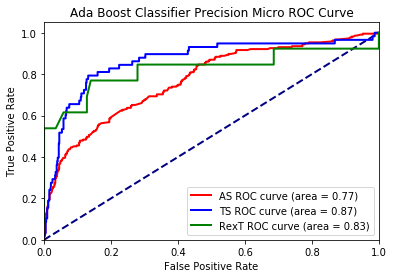

In [28]:
# ROC Curve precision micro
utils.model_roc_curves(roc_data_dict={'AS' : AS_random_forest_roc_curve, 
                                'TS' : TS_random_forest_roc_curve, 
                                'RexT' : RexT_random_forest_roc_curve}, 
                 auc_dict={'AS' : AS_random_forest_roc_curve_AUC, 
                           'TS' : TS_random_forest_roc_curve_AUC, 
                           'RexT' : RexT_random_forest_roc_curve_AUC}, 
                 method_name='Ada Boost Classifier Precision Micro')

TP to FP ratio: 2.18


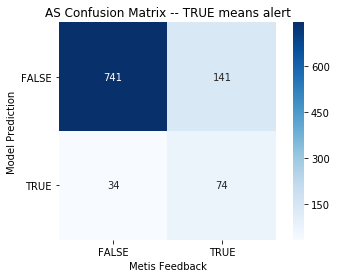

In [52]:
AS_threshold = 0.49
utils.confusion_matrix_visual(AS_y_test, 
                        AS_random_forest_model.predict_proba(AS_X_test)[:,1] \
                        >= AS_threshold, 'AS')

TP to FP ratio: 1.29


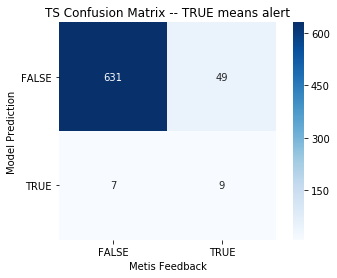

In [57]:
TS_threshold = 0.5
utils.confusion_matrix_visual(TS_y_test, 
                        TS_random_forest_model.predict_proba(TS_X_test)[:,1] \
                        >= TS_threshold,
                        'TS')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


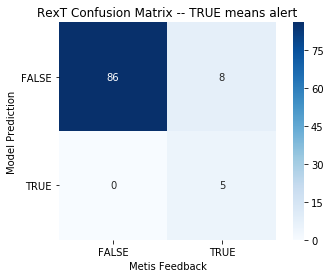

In [58]:
RexT_threshold = 0.1
utils.confusion_matrix_visual(RexT_y_test, 
                        RexT_random_forest_model.predict_proba(RexT_X_test)[:,1] \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 0.63


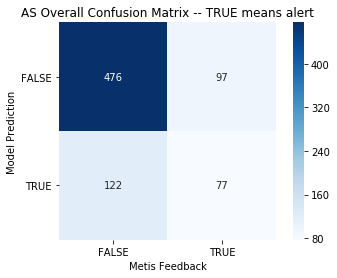

In [59]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_random_forest_model.predict_proba(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


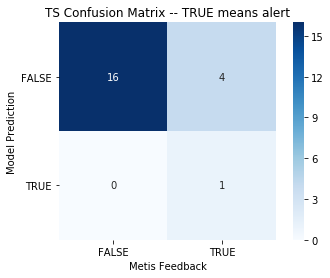

In [60]:
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_random_forest_model.predict_proba(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if 'diff' in col or col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [61]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test, 
                                       'TS' : TS_y_test, 
                                       'RexT' : RexT_y_test},
                         y_pred_dict={'AS' : 
                                      AS_random_forest_model.predict_proba(AS_X_test)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_random_forest_model.predict_proba(TS_X_test)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_random_forest_model.predict_proba(RexT_X_test)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.84      0.96      0.89       775
       True       0.69      0.34      0.46       215

avg / total       0.81      0.82      0.80       990

Percent misclassified: 17.68%
Count misclassified: 175
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.93      0.99      0.96       638
       True       0.56      0.16      0.24        58

avg / total       0.90      0.92      0.90       696

Percent misclassified: 8.05%
Count misclassified: 56
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.91      1.00      0.96        86
       True       1.00      0.38      0.56        13

avg / total       0.93      0.92      0.90        99

Percent misclassified: 8.08%
Count misclassified: 8


## Ada Boost Classifier with Differences

In [35]:
%%capture 
# ^ don't print errors about precision, recall, F1-score being 0

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score, precision_score, recall_score, fbeta_score, zero_one_loss

rfc_diff = AdaBoostClassifier(random_state=25)

parameters = {'n_estimators' : [50, 100, 150],
              'learning_rate' : [0.1, 0.5, 1, 1.5]
             }

scoring = {'auc': 'roc_auc',
           'precision_weighted' : make_scorer(precision_score, average='weighted'),
           'precision_binary' : make_scorer(precision_score, average='binary'),
           'precision_micro' : make_scorer(precision_score, average='micro'),
           'recall_weighted' : make_scorer(recall_score, average='weighted'),
           'recall_binary' : make_scorer(recall_score, average='binary'),
           'recall_micro' : make_scorer(recall_score, average='micro'),
           'f1_score_weighted' : make_scorer(f1_score, average='weighted'),
           'f1_score_binary' : make_scorer(f1_score, average='binary'),
           'f1_score_micro' : make_scorer(f1_score, average='micro'),
            # percent of misclassifications
           'zero_one_loss_normalized' : make_scorer(zero_one_loss, greater_is_better=False), 
            # number of misclassifications
           'zero_one_loss_count' : make_scorer(zero_one_loss, greater_is_better=False, normalize=False), 
           'accuracy' : 'accuracy'}

refit_AS = 'f1_score_binary'
refit_TS = 'f1_score_binary'
refit_RexT = 'f1_score_binary'

AS_rfc_diff = GridSearchCV(estimator=rfc_diff, param_grid=parameters, 
                      scoring=scoring, refit=refit_AS, return_train_score=True)
TS_rfc_diff = GridSearchCV(estimator=rfc_diff, param_grid=parameters, 
                      scoring=scoring, refit=refit_TS, return_train_score=True)
RexT_rfc_diff = GridSearchCV(estimator=rfc_diff, param_grid=parameters, 
                        scoring=scoring, refit=refit_RexT, return_train_score=True)

In [36]:
%%capture

AS_random_forest_model_diff = AS_rfc_diff.fit(AS_X_train_diff, AS_y_train_diff)
TS_random_forest_model_diff = TS_rfc_diff.fit(TS_X_train_diff, TS_y_train_diff)
RexT_random_forest_model_diff = RexT_rfc_diff.fit(RexT_X_train_diff, RexT_y_train_diff)

In [37]:
print(AS_rfc_diff.best_estimator_)
print(TS_rfc_diff.best_estimator_)
print(RexT_rfc_diff.best_estimator_)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=150, random_state=25)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=50, random_state=25)
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.5, n_estimators=50, random_state=25)


In [38]:
print('AS feature importances\n------')
for feature, importance in zip(AS_X_train_diff.columns, 
                               AS_random_forest_model_diff.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))
print('-----------------------------\nTS feature importances\n------')
for feature, importance in zip(TS_X_train_diff.columns, 
                               TS_random_forest_model_diff.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))
print('-----------------------------\nRexT feature importances\n------')
for feature, importance in zip(RexT_X_train_diff.columns, 
                               RexT_random_forest_model_diff.best_estimator_.feature_importances_):
    print(feature + '\t' + str(round(importance, 2)))

AS feature importances
------
is_campaign	0.01
time_delta_01	0.08
time_delta_02	0.03
time_delta_03	0.01
time_delta_04	0.01
time_delta_05	0.03
time_delta_06	0.01
time_delta_07	0.03
time_delta_08	0.05
time_delta_09	0.02
time_delta_10	0.03
time_delta_11	0.0
time_delta_12	0.01
time_delta_13	0.01
time_delta_14	0.03
time_delta_15	0.01
time_delta_16	0.05
time_delta_17	0.04
time_delta_18	0.01
time_delta_19	0.04
time_delta_20	0.0
time_delta_21	0.03
time_delta_22	0.03
time_delta_23	0.02
time_delta_24	0.01
time_delta_25	0.02
kpi_clicks	0.01
kpi_client_rext	0.0
kpi_conversions	0.0
kpi_cos	0.0
kpi_cr	0.0
kpi_ctr	0.0
kpi_displays	0.0
kpi_margin	0.01
kpi_order_value	0.0
kpi_rext_euro	0.01
kpi_spend	0.0
kpi_tac	0.01
time_delta_diff_24	0.01
time_delta_diff_23	0.01
time_delta_diff_22	0.01
time_delta_diff_21	0.0
time_delta_diff_20	0.01
time_delta_diff_19	0.0
time_delta_diff_18	0.01
time_delta_diff_17	0.01
time_delta_diff_16	0.01
time_delta_diff_15	0.0
time_delta_diff_14	0.0
time_delta_diff_13	0.03
time_d

In [39]:
from sklearn.metrics import roc_curve, auc

AS_y_prob_fit_diff = AS_random_forest_model_diff.predict_proba(AS_X_test_diff)
TS_y_prob_fit_diff = TS_random_forest_model_diff.predict_proba(TS_X_test_diff)
RexT_y_prob_fit_diff = RexT_random_forest_model_diff.predict_proba(RexT_X_test_diff)

AS_random_forest_roc_curve_diff = roc_curve(AS_y_test_diff, AS_y_prob_fit_diff[:,1], 
                                               pos_label=1) # returns tuple: fpr, tpr, thresholds
AS_random_forest_roc_curve_AUC_diff = auc(AS_random_forest_roc_curve_diff[0], 
                                            AS_random_forest_roc_curve_diff[1]) # needs fpr, tpr
TS_random_forest_roc_curve_diff = roc_curve(TS_y_test_diff, TS_y_prob_fit_diff[:,1], pos_label=1)
TS_random_forest_roc_curve_AUC_diff = auc(TS_random_forest_roc_curve_diff[0], 
                                            TS_random_forest_roc_curve_diff[1])
RexT_random_forest_roc_curve_diff = roc_curve(RexT_y_test_diff, RexT_y_prob_fit_diff[:,1], pos_label=1)
RexT_random_forest_roc_curve_AUC_diff = auc(RexT_random_forest_roc_curve_diff[0], 
                                              RexT_random_forest_roc_curve_diff[1])

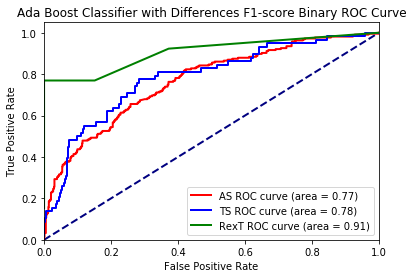

In [40]:
# ROC Curve
utils.model_roc_curves(roc_data_dict={'AS' : AS_random_forest_roc_curve_diff, 
                                'TS' : TS_random_forest_roc_curve_diff, 
                                'RexT' : RexT_random_forest_roc_curve_diff}, 
                 auc_dict={'AS' : AS_random_forest_roc_curve_AUC_diff, 
                           'TS' : TS_random_forest_roc_curve_AUC_diff, 
                           'RexT' : RexT_random_forest_roc_curve_AUC_diff}, 
                 method_name='Ada Boost Classifier with Differences F1-score Binary')

TP to FP ratio: 1.29


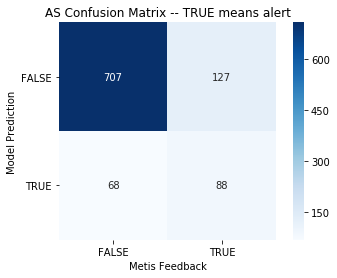

In [67]:
AS_threshold = 0.5
utils.confusion_matrix_visual(AS_y_test_diff, 
                                AS_random_forest_model_diff.predict_proba(AS_X_test_diff)[:,1] \
                                >= AS_threshold, 'AS')

TP to FP ratio: 0.26


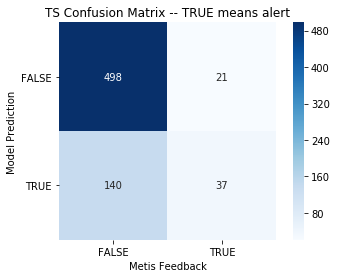

In [74]:
TS_threshold = 0.49
utils.confusion_matrix_visual(TS_y_test_diff, 
                                TS_random_forest_model_diff.predict_proba(TS_X_test_diff)[:,1] \
                                >= TS_threshold,
                                'TS')

TP to FP ratio: inf


C:\Users\s.molin\scope_model_case_study\pymodelutils\utils.py:259: RuntimeWarning: divide by zero encountered in longlong_scalars
  print('TP to FP ratio: ' + str(round(mat[1,1] / mat[0,1], 2)))


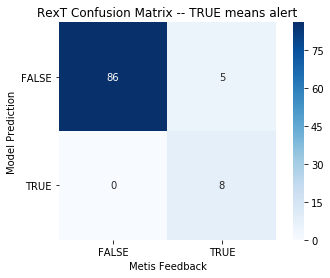

In [80]:
RexT_threshold = 0.005
utils.confusion_matrix_visual(RexT_y_test_diff, 
                        RexT_random_forest_model_diff.predict_proba(RexT_X_test_diff)[:,1] \
                        >= RexT_threshold,
                        'RexT')

On disqualified data.

TP to FP ratio: 0.95


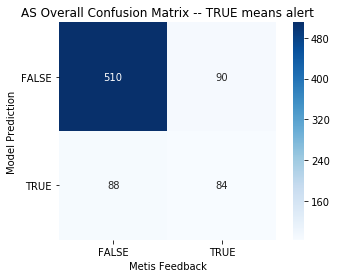

In [81]:
utils.confusion_matrix_visual(disqualified_AS['min_max']['is_alert'], 
                        AS_random_forest_model_diff.predict_proba(disqualified_AS['min_max'].\
                                                                   drop([col for col in disqualified_AS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= AS_threshold, 'AS Overall')

TP to FP ratio: 0.5


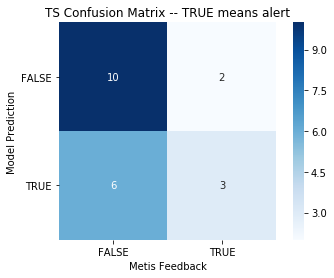

In [82]:
utils.confusion_matrix_visual(disqualified_TS['min_max']['is_alert'], 
                        TS_random_forest_model_diff.predict_proba(disqualified_TS['min_max'].\
                                                                   drop([col for col in disqualified_TS['min_max'].columns
                                                                        if col in ['run_date', 'series', 'is_alert']], axis=1))[:,1] \
                        >= TS_threshold,
                        'TS')

#### Metrics

In [83]:
utils.classification_report_all(y_test_dict={'AS' : AS_y_test_diff, 
                                       'TS' : TS_y_test_diff, 
                                       'RexT' : RexT_y_test_diff},
                         y_pred_dict={'AS' : 
                                      AS_random_forest_model_diff.predict_proba(AS_X_test_diff)[:,1] >= \
                                      AS_threshold, 
                                      'TS' : 
                                      TS_random_forest_model_diff.predict_proba(TS_X_test_diff)[:,1] >= \
                                      TS_threshold, 
                                      'RexT' : 
                                      RexT_random_forest_model_diff.predict_proba(RexT_X_test_diff)[:,1] >= \
                                      RexT_threshold})

AS results
             precision    recall  f1-score   support

      False       0.85      0.91      0.88       775
       True       0.56      0.41      0.47       215

avg / total       0.79      0.80      0.79       990

Percent misclassified: 19.7%
Count misclassified: 195
------------------------------------------------------
TS results
             precision    recall  f1-score   support

      False       0.96      0.78      0.86       638
       True       0.21      0.64      0.31        58

avg / total       0.90      0.77      0.82       696

Percent misclassified: 23.13%
Count misclassified: 161
------------------------------------------------------
RexT results
             precision    recall  f1-score   support

      False       0.95      1.00      0.97        86
       True       1.00      0.62      0.76        13

avg / total       0.95      0.95      0.94        99

Percent misclassified: 5.05%
Count misclassified: 5
